# 批量归一化
固定小批量里面的均值和方差
$$\mu_B=\frac{1}{|B|}\sum_{i\in B}x_i\mathrm{~and~}\sigma_B^2=\frac{1}{|B|}\sum_{i\in B}(x_i-\mu_B)^2+\epsilon $$
然后再做额外的调整(可学习的参数)
$$x_{i+1}=\gamma\frac{x_i-\mu_B}{\sigma_B}+\beta $$


# 批量归一化
损失出现在最后，后面的层训练较快
数据在最底部
底部的层训练较慢
底部层一变化，所有都得跟着变
最后的那些层需要重新学习多次
·导致收敛变慢
我们可以在学习底部层的时候避免变化顶部层吗?

# 批量归一化层
·可学习的参数为$\gamma$和$\beta$
·作用在
·全连接层和卷积层输出上，激活函数前
·全连接层和卷积层输入上
·对全连接层，作用在特征维
·对于卷积层，作用在通道维

# 批量归一化在做什么?
·最初论文是想用它来减少内部协变量转移
·后续有论文指出它可能就是通过在每个小批量里加入噪音来控制模型复杂度
$$x_{i+1}=\gamma\frac{x_i-\hat{\mu}_B}{\hat{\sigma}_B}+\beta $$
·因此没必要跟丢弃法混合使用

# 总结
批量归一化固定小批量中的均值和方差，然后学习出适合的偏移和缩放
·可以加速收敛速度，但一般不改变模型精度

从零实现

In [2]:
import torch
from torch import nn
from d2l import torch as d2l


# 这段代码可以了解一下卡尔曼滤波
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    """
    :param X:
    :param gamma: 可学习参数
    :param beta: 可学习参数
    :param moving_mean: 近似的认为是全局的均值方差，不是小批量的
    :param moving_var: 近似的认为是全局的均值方差，不是小批量的
    :param eps:
    :param momentum:
    :return:
    """
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

创建一个正确的BatchNorm图层

In [3]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moning_var = torch.ones(shape)

    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moning_var = self.moning_var.to(X.device)
        Y, self.moving_mean, self.moning_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moning_var,
            eps=1e-5, momentum=0.9
        )
        return Y

应用BatchNorm于LeNet模型

In [4]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
    BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
    nn.Sigmoid(), nn.Linear(84, 10)
)

在Fashion-MNIST数据集上训练模型

KeyboardInterrupt: 

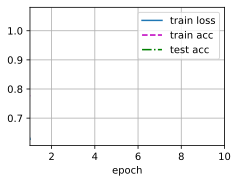

In [5]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

拉伸参数gamma和偏移参数beta

In [5]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([1., 1., 1., 1., 1., 1.], grad_fn=<ReshapeAliasBackward0>),
 tensor([0., 0., 0., 0., 0., 0.], grad_fn=<ReshapeAliasBackward0>))

简明实现

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), nn.Linear(256, 120), nn.BatchNorm1d(120),
    nn.Sigmoid(), nn.Linear(120, 84), nn.BatchNorm1d(84),
    nn.Sigmoid(), nn.Linear(84, 10)
)

使用相同超参数来训练模型

In [ ]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [2]:
a = torch.rand((2, 4))
a

tensor([[0.5799, 0.2557, 0.3714, 0.4530],
        [0.9626, 0.4341, 0.7665, 0.8736]])

In [3]:
a.mean(dim=0)

tensor([0.7712, 0.3449, 0.5689, 0.6633])

In [4]:
a.mean(dim=1)

tensor([0.4150, 0.7592])